In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Bidirectional
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
from tensorflow.keras import backend as K

In [2]:
tf.keras.backend.clear_session()
warnings.filterwarnings("ignore", category=FutureWarning)
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# tf.config.set_visible_devices([], 'GPU')

In [3]:
# print("Visible devices:", tf.config.list_physical_devices())

In [4]:
# # Check devices
# print("Available devices:", tf.config.list_physical_devices())

# # Verify no GPU is being used
# assert not tf.config.list_physical_devices('GPU'), "GPU is still enabled!"
# print("TensorFlow is running on CPU only.")

In [5]:
# Set display options
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [6]:
train_residuals_df = pd.read_csv("../data/final/train_residuals_df.csv", parse_dates=["Date"], index_col="Date")
test_residuals_df = pd.read_csv("../data/final/test_residuals_df.csv", parse_dates=["Date"], index_col="Date")

# Fit into LSTM model

In [7]:
train_residual = train_residuals_df["Residuals"]
test_residual = test_residuals_df["Residuals"]

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_residual_scaled = scaler.fit_transform(train_residual.values.reshape(-1, 1))
test_residual_scaled = scaler.transform(test_residual.values.reshape(-1, 1))

# save scaler
joblib.dump(scaler, "../models/residual_scaler.pkl")

['../models/residual_scaler.pkl']

In [9]:
look_back = 7  # Use a larger look_back window

def create_lstm_dataset(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])  # Input sequence
        y.append(data[i+look_back, 0])   # Next value (target)
    return np.array(X), np.array(y)

X_train, y_train = create_lstm_dataset(train_residual_scaled, look_back)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = create_lstm_dataset(test_residual_scaled, look_back)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for LSTM

print("X shape:", X_train.shape)
print("y shape:", y_train.shape)
print("Reshaped X shape:", X_train.shape)

# print shape respectively for X_test
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X shape: (724, 7, 1)
y shape: (724,)
Reshaped X shape: (724, 7, 1)
X_test shape: (724, 7, 1)
y_test shape: (724,)


# Attention-based LSTM

In [10]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations, backend as K
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], 1),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias", shape=(1,), initializer="zeros", trainable=True
        )
        super(Attention, self).build(input_shape)

    @tf.function(reduce_retracing=True)
    def call(self, x):
        # Use activations.tanh instead of K.tanh
        score = activations.tanh(K.dot(x, self.W) + self.b)
        # attention_weights = activations.softmax(score, axis=1)
        attention_weights = activations.softmax(score / 0.1, axis=1)
        context_vector = x * attention_weights
        # return K.sum(context_vector, axis=1)
        return tf.reduce_sum(context_vector, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [11]:
def build_lstm(input_shape, units=100, dropout=0.2):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units, activation='relu', return_sequences=True),
        Dropout(dropout),
        LSTM(units//2, activation='relu'),
        Dropout(dropout),
        Dense(1)
    ])
    return model

In [12]:
def build_bilstm(input_shape, units=100, dropout=0.2):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(units, activation='relu', return_sequences=True)),
        Dropout(dropout),
        LSTM(units // 2, activation='relu'),
        Dropout(dropout),
        Dense(1)
    ])
    return model

In [13]:
def build_attention_lstm(input_shape, units=100, dropout=0.2):
    inputs = Input(shape=input_shape)
    x = LSTM(units, activation='relu', return_sequences=True)(inputs)
    x = Dropout(dropout)(x)
    x = LSTM(units // 2, activation='relu', return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = Attention()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

In [14]:
def build_attention_bilstm(input_shape, units=100, dropout=0.25):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, activation='relu', return_sequences=True))(inputs)
    x = Dropout(dropout)(x)
    x = LSTM(units // 2, activation='relu', return_sequences=True)(x)
    x = Dropout(dropout)(x)
    x = Attention()(x)
    outputs = Dense(1)(x)
    return Model(inputs, outputs)

In [15]:
def lstm_model_builder(model_type="LSTM", units=100, dropout=0.2, learning_rate=0.001):
    # Select architecture function dynamically
    if model_type == "LSTM":
        model = build_lstm(input_shape=(look_back, 1), units=units, dropout=dropout)
    elif model_type == "BiLSTM":
        model = build_bilstm(input_shape=(look_back, 1), units=units, dropout=dropout)
    elif model_type == "Attention-LSTM":
        model = build_attention_lstm(input_shape=(look_back, 1), units=units, dropout=dropout)
    elif model_type == "Attention-BiLSTM":
        model = build_attention_bilstm(input_shape=(look_back, 1), units=units, dropout=dropout)
    else:
        raise ValueError(f"Invalid model_type: {model_type}")

    # Compile the model with the specified learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

### Hyperparameters Tuning

In [ ]:
# Define parameter grid
param_grid = {
    "units": [50, 100, 150],        # Number of units
    "dropout": [0.2, 0.3, 0.4],     # Dropout rate
    "learning_rate": [0.001, 0.0001],  # Learning rate
    "batch_size": [16, 32],    # Batch size
}

# Define TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Map model types to their respective build functions
model_types = ["LSTM", "BiLSTM", "Attention-LSTM", "Attention-BiLSTM"]
best_params = {}
best_models = {}

for model_type in model_types:
    print(f"Performing GridSearchCV for {model_type}...")

    model_wrapper = KerasRegressor(
        model=lstm_model_builder,
        model_type=model_type,  # Pass hyperparameters here
        units=100,
        dropout=0.2,
        learning_rate=0.001,
        epochs=20,
        verbose=0,
        validation_split=0.2  # Use validation split for tuning
    )

    # Grid search
    grid_search = GridSearchCV(
        estimator=model_wrapper,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=tscv,  # Use TimeSeriesSplit for cross-validation
        verbose=2
    )

    # Fit grid search on the training data
    grid_search.fit(X_train, y_train)

    # Save the best parameters and model
    best_params[model_type] = grid_search.best_params_
    best_models[model_type] = grid_search.best_estimator_

    print(f"Best parameters for {model_type}: {grid_search.best_params_}")



In [ ]:
# # Save best models and parameters for each LSTM variant
# for model_type, model in best_models.items():
#     model_file = f"../models/lookback7/{model_type}_best_model.pkl"
#     param_file = f"../models/lookback7/{model_type}_best_params.pkl"
    
#     # Save the model using joblib
#     joblib.dump(model, model_file)
#     joblib.dump(best_params[model_type], param_file)
    
#     print(f"Saved {model_type} best model to {model_file}")
#     print(f"Saved {model_type} best parameters to {param_file}")

### Prediction

In [18]:
# # Initialize dictionary to store results
# predictions = {}
# evaluation_metrics = {}

# for model_type in ["LSTM", "BiLSTM", "Attention-LSTM", "Attention-BiLSTM"]:
#     # Load the best model and parameters
#     model_file = f"../models/{model_type}_best_model.pkl"
#     param_file = f"../models/{model_type}_best_params.pkl"

#     # print(f"Loading {model_type} model and parameters...")
#     best_model = joblib.load(model_file)
#     best_params = joblib.load(param_file)
    
#     # print(f"Best parameters for {model_type}: {best_params}")

#     # Evaluate on the test set
#     y_pred = best_model.predict(X_test)

#     # Inverse transform the predictions
#     y_pred_inverse = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

#     # Flatten the original y_test for consistency in metrics calculation
#     y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

#     # Store the inverse-transformed predictions
#     predictions[model_type] = y_pred_inverse

#     # Calculate metrics using the inverse-transformed values
#     rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
#     mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
#     mape = (np.abs((y_test_inverse - y_pred_inverse) / (y_test_inverse + 1e-10)).mean()) * 100

#     # Store the results
#     evaluation_metrics[model_type] = {
#         "RMSE": rmse,
#         "MAE": mae,
#         "MAPE": mape,
#         "Best params": best_params
#     }

#     # print(f"Evaluation metrics for {model_type}: RMSE={rmse}, MAE={mae}, MAPE={mape}")

# metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index').reset_index()
# metrics_df.columns = ["Model_Type", "RMSE", "MAE", "MAPE", "Best params"]
# metrics_df

### Prediction with uncertainties (MC Dropout)

In [19]:
# Initialize dictionaries to store results
predictions = {}
uncertainties = {}
evaluation_metrics = {}

# Perform predictions using MC Dropout
for model_type in ["LSTM", "BiLSTM", "Attention-LSTM", "Attention-BiLSTM"]:
    # Load the best model and parameters
    model_file = f"../models/lookback7/{model_type}_best_model.pkl"
    param_file = f"../models/lookback7/{model_type}_best_params.pkl"

    # print(f"Loading {model_type} model and parameters...")
    best_model = joblib.load(model_file)
    best_params = joblib.load(param_file)

    # print(f"Best parameters for {model_type}: {best_params}")

    # Access the underlying Keras model
    keras_model = best_model.model_

    # Perform 100 stochastic forward passes (Monte Carlo Dropout)
    n_simulations = 100
    preds = []

    for _ in range(n_simulations):
        # Enable dropout by setting training=True
        pred = keras_model(X_test, training=True)
        preds.append(pred.numpy())  # Convert to NumPy array

    preds = np.array(preds)  # Shape: (n_simulations, n_samples, n_outputs)

    # Compute mean prediction and uncertainty
    mean_pred = np.mean(preds, axis=0)  # Mean prediction
    uncertainty = np.std(preds, axis=0)  # Uncertainty (standard deviation)

    # Inverse transform the mean predictions
    mean_pred_inverse = scaler.inverse_transform(mean_pred.reshape(-1, 1)).flatten()
    y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Store the predictions and uncertainties
    predictions[model_type] = mean_pred_inverse
    uncertainties[model_type] = uncertainty

    # Calculate metrics using the inverse-transformed mean predictions
    rmse = np.sqrt(mean_squared_error(y_test_inverse, mean_pred_inverse))
    mae = mean_absolute_error(y_test_inverse, mean_pred_inverse)
    mape = (np.abs((y_test_inverse - mean_pred_inverse) / (y_test_inverse + 1e-10)).mean()) * 100

    # Store the results
    evaluation_metrics[model_type] = {
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "Best params": best_params
    }

    # print(f"Evaluation metrics for {model_type}: RMSE={rmse}, MAE={mae}, MAPE={mape}")

In [20]:
# Ensemble Prediction
print("\nCalculating Ensemble Prediction...")
ensemble_mean_pred = np.mean([predictions[model_type] for model_type in predictions], axis=0)
ensemble_variance = np.sum([uncertainties[model_type]**2 for model_type in uncertainties], axis=0)
ensemble_uncertainty = np.sqrt(ensemble_variance)  # Ensemble uncertainty as std dev

# Store the predictions and uncertainties
predictions["Ensemble-LSTM"] = ensemble_mean_pred
uncertainties["Ensemble-LSTM"] = ensemble_uncertainty

# Save the prediction and uncertainty results
for model_type in predictions.keys():
    np.save(f"../results/predictions/test/lookback7/{model_type}_pred.npy", predictions[model_type])
    np.save(f"../results/predictions/test/lookback7/{model_type}_uncertainty.npy", uncertainties[model_type])
    print(f"Saved for {model_type}")


Calculating Ensemble Prediction...
Saved for LSTM
Saved for BiLSTM
Saved for Attention-LSTM
Saved for Attention-BiLSTM
Saved for Ensemble


In [21]:
# Calculate metrics for the ensemble
rmse = np.sqrt(mean_squared_error(y_test_inverse, ensemble_mean_pred))
mae = mean_absolute_error(y_test_inverse, ensemble_mean_pred)
mape = (np.abs((y_test_inverse - ensemble_mean_pred) / (y_test_inverse + 1e-10)).mean()) * 100

# Store ensemble metrics
evaluation_metrics["Ensemble-LSTM"] = {
    "RMSE": rmse,
    "MAE": mae,
    "MAPE": mape,
    "Best params": "N/A (Ensemble)"
}

# Convert evaluation metrics to a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict(evaluation_metrics, orient='index').reset_index()
metrics_df.columns = ["Model_Type", "RMSE", "MAE", "MAPE", "Best params"]

metrics_df.to_csv("../results/metrics/lookback7/lstm_metrics.csv", index=False)

metrics_df

,Model_Type,RMSE,MAE,MAPE,Best params
0,LSTM,0.15,0.11,50.52,"{'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.001, 'units': 150}"
1,BiLSTM,0.12,0.09,145.14,"{'batch_size': 16, 'dropout': 0.4, 'learning_rate': 0.001, 'units': 100}"
2,Attention-LSTM,0.14,0.11,73.53,"{'batch_size': 16, 'dropout': 0.2, 'learning_rate': 0.001, 'units': 150}"
3,Attention-BiLSTM,0.13,0.10,101.23,"{'batch_size': 16, 'dropout': 0.3, 'learning_rate': 0.001, 'units': 150}"
4,Ensemble,0.11,0.08,67.66,N/A (Ensemble)


### Visualization on Test Set

In [319]:
test_pca_df = pd.read_csv("../data/final/test_pca_df.csv", parse_dates=["Date"], index_col="Date")
test_actual_values = np.exp(test_pca_df["btc_close"]) - 1
test_arima_garch_pred = test_residuals_df["SARIMA-GARCH Prediction"]
test_arima_garch_pred_org = np.exp(test_arima_garch_pred) - 1

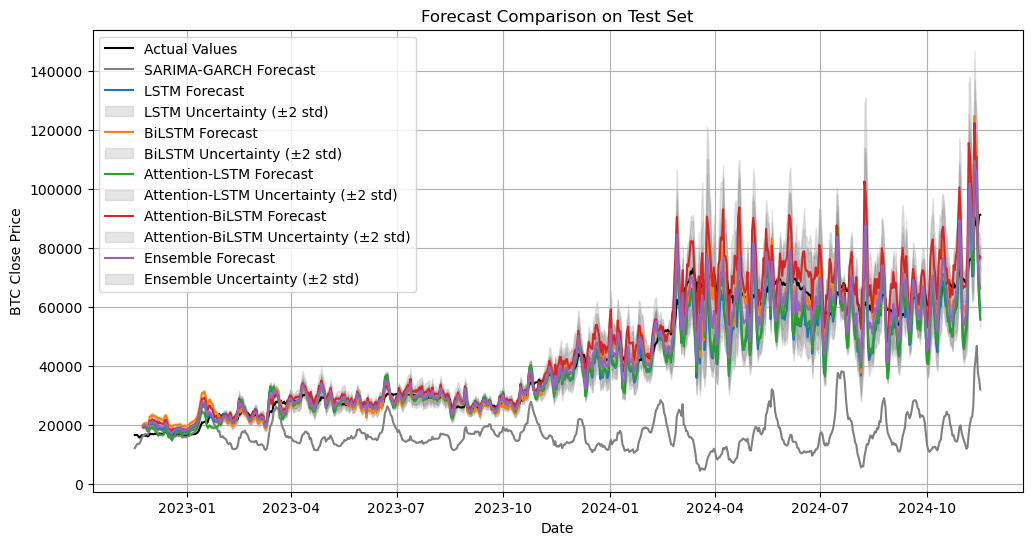

In [ ]:
# # Plot in same figure
# plt.figure(figsize=(12, 6))
# plt.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
# plt.plot(test_pca_df.index,test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")

# for name, pred in predictions.items():
#     # reshape pred
#     pred = pred.reshape(-1,1)
#     # Undo log transform for the combined forecast
#     test_final_forecast = test_arima_garch_pred.iloc[look_back:].values.reshape(-1,1) + pred
#     lstm_pred_original = np.exp(test_final_forecast) - 1

#     # Store the result in the dictionary
#     # final_forecast_lstm_dict[name] = lstm_pred_original

#     # Plot LSTM variant predictions
#     plt.plot(test_pca_df.index[look_back:], lstm_pred_original, label=f"{name} Forecast")

#     # Add uncertainty (if available)
#     uncertainty = uncertainties.get(name)
#     if uncertainty is not None:
#         uncertainty = uncertainty.reshape(-1, 1)
#         lower_bound = np.exp(test_final_forecast - 2 * uncertainty) - 1  # Lower bound (95% CI)
#         upper_bound = np.exp(test_final_forecast + 2 * uncertainty) - 1  # Upper bound (95% CI)

#         # Plot uncertainty bands
#         plt.fill_between(
#             test_pca_df.index[look_back:],
#             lower_bound.flatten(),
#             upper_bound.flatten(),
#             color="gray",
#             alpha=0.2,
#             label=f"{name} Uncertainty (±2 std)"
#         )

# plt.title("Forecast Comparison on Test Set")
# plt.xlabel("Date")
# plt.ylabel("BTC Close Price")
# plt.legend()
# plt.grid()
# # plt.savefig("../results/images/test/merge.png")
# plt.show()
# plt.close()

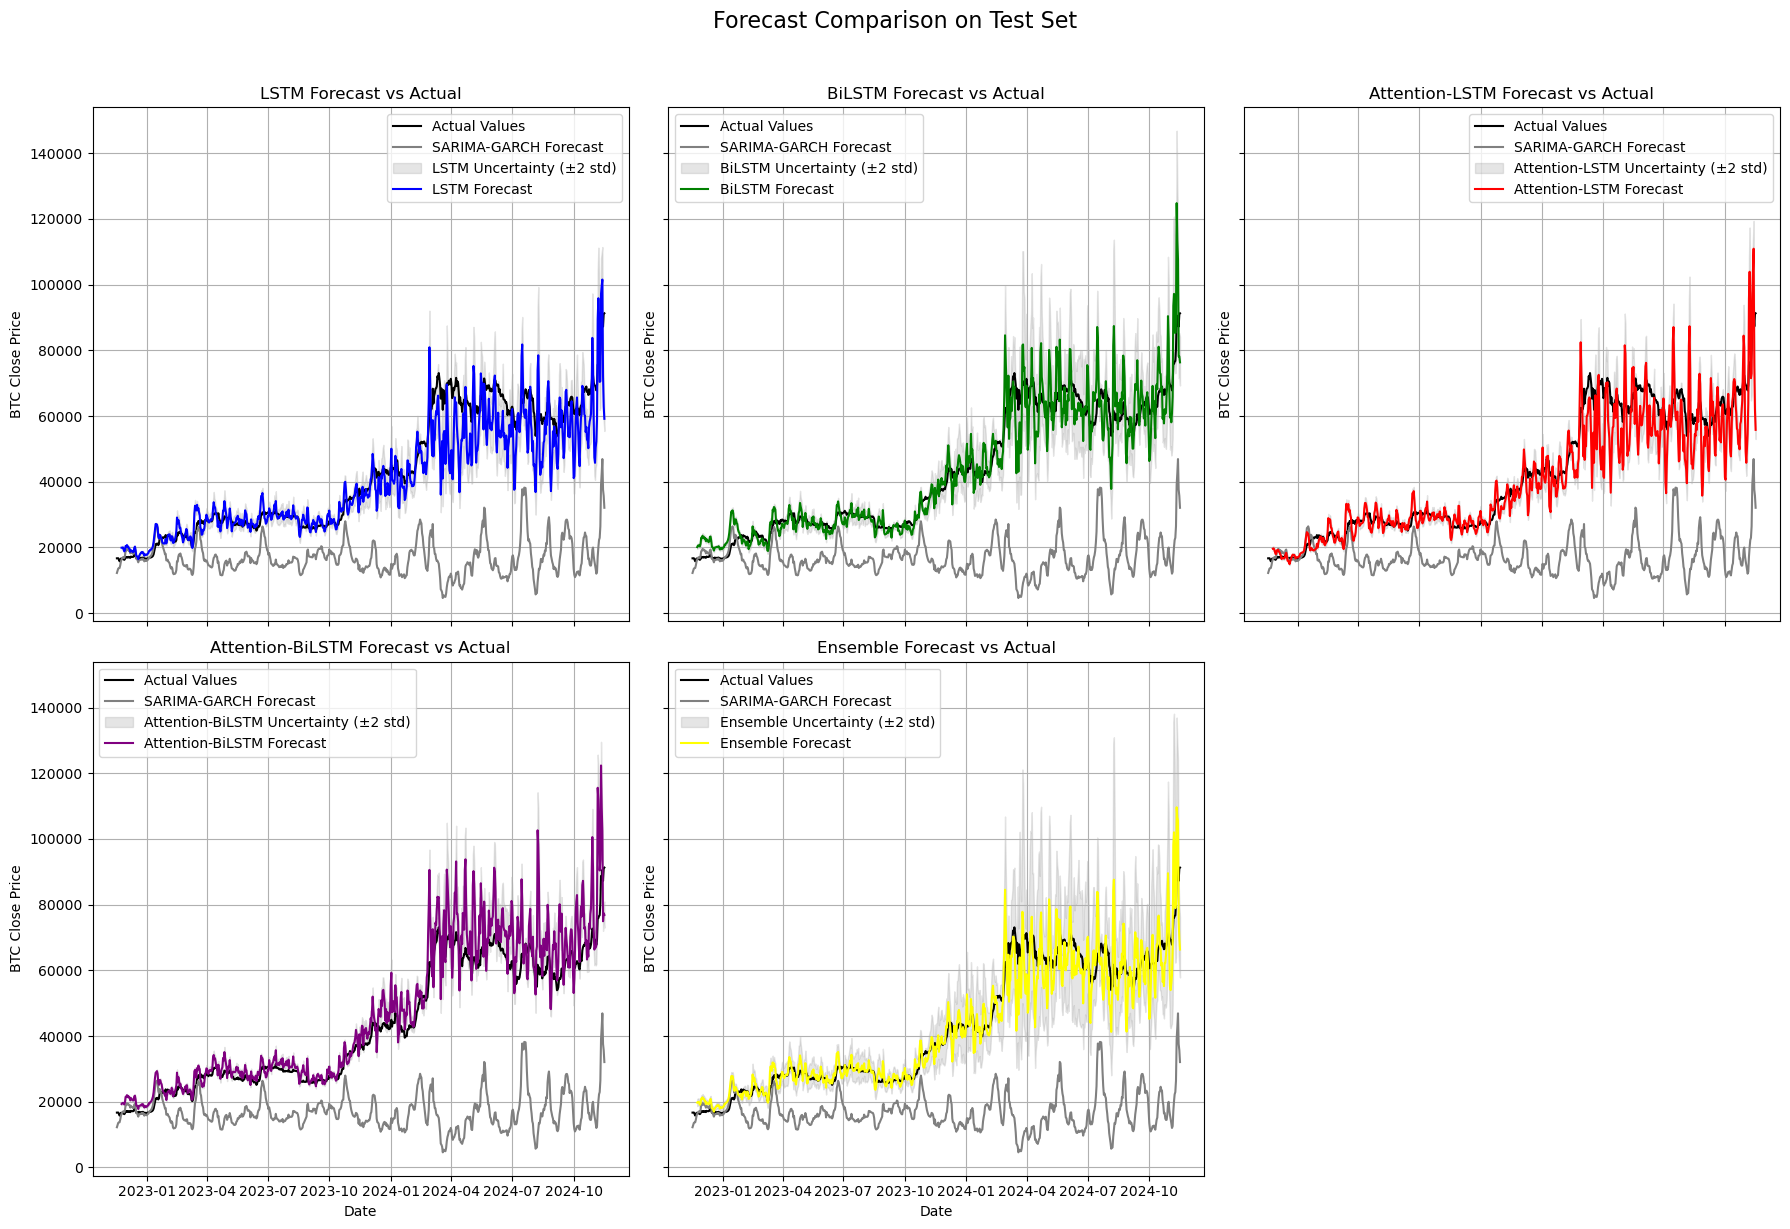

In [24]:
# Combined plot with subplots
# Number of models (LSTM variants)
n_models = len(predictions)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a color palette for the predictions
colors = ["blue", "green", "red", "purple", "yellow"]  # Add more colors if needed

# Add a general title for the entire plot
fig.suptitle("Forecast Comparison on Test Set", fontsize=16, y=1.02)

# Plot actual values and SARIMA-GARCH forecast in each subplot
for ax in axes[:n_models]:
    ax.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
    ax.plot(test_pca_df.index, test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")

# Plot each LSTM variant prediction in a separate subplot
for i, (name, pred) in enumerate(predictions.items()):
    # Reshape pred
    pred = pred.reshape(-1, 1)
    
    # Undo log transform for the combined forecast
    test_final_forecast = test_arima_garch_pred.iloc[look_back:].values.reshape(-1, 1) + pred
    lstm_pred_original = np.exp(test_final_forecast) - 1

    # Add uncertainty (if available)
    uncertainty = uncertainties.get(name)
    if uncertainty is not None:
        uncertainty = uncertainty.reshape(-1, 1)
        lower_bound = np.exp(test_final_forecast - 2 * uncertainty) - 1  # Lower bound (95% CI)
        upper_bound = np.exp(test_final_forecast + 2 * uncertainty) - 1  # Upper bound (95% CI)

        # Plot uncertainty bands
        axes[i].fill_between(
            test_pca_df.index[look_back:],
            lower_bound.flatten(),
            upper_bound.flatten(),
            color="gray",
            alpha=0.2,
            label=f"{name} Uncertainty (±2 std)"
        )

    # Plot LSTM variant predictions
    axes[i].plot(
        test_pca_df.index[look_back:],
        lstm_pred_original,
        label=f"{name} Forecast",
        color=colors[i]
    )

    # Set subplot title and labels
    axes[i].set_title(f"{name} Forecast vs Actual")
    axes[i].set_ylabel("BTC Close Price")
    axes[i].legend()
    axes[i].grid()

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")  # Hide unused subplots

# Set common x-label for all subplots
for ax in axes[-3:]:  # Only set x-label for the bottom row
    ax.set_xlabel("Date")

# Adjust layout for better spacing
plt.tight_layout()

# plt.savefig("../results/images/test/subplot.png")
plt.show()
plt.close()

In [ ]:
# # Separate plots for each LSTM variant
# # Number of models (LSTM variants)
# n_models = len(predictions)

# # Define a color palette for the predictions
# colors = ["blue", "green", "red", "purple", "yellow"]  # Add more colors if needed

# # Loop through each LSTM variant and create a separate plot
# for i, (name, pred) in enumerate(predictions.items()):
#     # Create a new figure for each model
#     fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figsize for better visibility
    
#     # Plot actual values and SARIMA-GARCH forecast
#     ax.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
#     ax.plot(test_pca_df.index, test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")
    
#     # Reshape pred
#     pred = pred.reshape(-1, 1)
    
#     # Undo log transform for the combined forecast
#     test_final_forecast = test_arima_garch_pred.iloc[look_back:].values.reshape(-1, 1) + pred
#     lstm_pred_original = np.exp(test_final_forecast) - 1

#     # Add uncertainty (if available)
#     uncertainty = uncertainties.get(name)
#     if uncertainty is not None:
#         uncertainty = uncertainty.reshape(-1, 1)
#         lower_bound = np.exp(test_final_forecast - 2 * uncertainty) - 1  # Lower bound (95% CI)
#         upper_bound = np.exp(test_final_forecast + 2 * uncertainty) - 1  # Upper bound (95% CI)

#         # Plot uncertainty bands
#         ax.fill_between(
#             test_pca_df.index[look_back:],
#             lower_bound.flatten(),
#             upper_bound.flatten(),
#             color="gray",
#             alpha=0.2,
#             label=f"{name} Uncertainty (±2 std)"
#         )

#     # Plot LSTM variant predictions
#     ax.plot(
#         test_pca_df.index[look_back:],
#         lstm_pred_original,
#         label=f"{name} Forecast",
#         color=colors[i]
#     )

#     # Set plot title and labels
#     ax.set_title(f"{name} Forecast vs Actual", fontsize=14)
#     ax.set_ylabel("BTC Close Price", fontsize=12)
#     ax.set_xlabel("Date", fontsize=12)
#     ax.legend()
#     ax.grid()

#     # Adjust layout for better spacing
#     plt.tight_layout()

#     # Save the figure as a separate image
#     # plt.savefig(f"../results/images/test/{name}.png")
#     plt.show()
#     plt.close()

In [43]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

In [322]:
train_pca_df = pd.read_csv("../data/final/train_pca_df.csv", parse_dates=["Date"], index_col="Date")
val_pca_df = pd.read_csv("../data/final/val_pca_df.csv", parse_dates=["Date"], index_col="Date")

In [329]:
future_days = 7  # Number of days to predict
val_exog = val_pca_df.drop(columns=["btc_close"])
test_exog = test_pca_df.drop(columns=["btc_close"])
# concat val and test exog
exog = pd.concat([val_exog, test_exog])

future_dates = pd.date_range(start=exog.index[-1] + pd.Timedelta(days=1), periods=future_days, freq="D")

# Create a DataFrame to store predicted values
future_exog = pd.DataFrame(index=future_dates, columns=exog.columns)

# Predict future values for each exogenous variable
for col in exog.columns:
    # Extract SARIMA parameters for the current indicator from sarima_params
    # Fit ARIMA to the historical data
    model = SARIMAX(exog[col], order=(1,1,3)) 
    model_fit = model.fit(disp=False)

    # Forecast future values
    forecast = model_fit.forecast(steps=future_days)
    future_exog[col] = forecast

future_exog

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
2024-11-17 00:00:00+00:00,15.31,-0.85,22.43,7.10,-2.78,-5.58,0.03,-0.14,14.32
2024-11-18 00:00:00+00:00,15.31,-1.01,22.79,7.09,-2.83,-5.35,0.44,-0.35,14.38
2024-11-19 00:00:00+00:00,15.31,-1.14,23.05,7.10,-2.88,-5.23,0.70,-0.45,14.38
2024-11-20 00:00:00+00:00,15.31,-1.23,23.22,7.10,-2.90,-5.18,0.84,-0.53,14.39
2024-11-21 00:00:00+00:00,15.31,-1.30,23.35,7.10,-2.91,-5.16,0.92,-0.61,14.39
2024-11-22 00:00:00+00:00,15.31,-1.36,23.44,7.10,-2.92,-5.15,0.96,-0.68,14.39
2024-11-23 00:00:00+00:00,15.31,-1.40,23.50,7.10,-2.92,-5.15,0.98,-0.74,14.39


In [330]:
# Load the ARIMAX model
arimax_results = joblib.load("../models/arimax_model.pkl")
garch_fit = joblib.load("../models/garch_model.pkl")

# Forecast ARIMAX for the next 6 days
arimax_forecast_future = arimax_results.forecast(steps=future_days, exog=future_exog).values.flatten()

# Forecast GARCH for the next 6 days
garch_forecast_future = garch_fit.forecast(horizon=future_days, method='simulation').variance.values[-1]

random_noise = np.random.normal(loc=0, scale=garch_forecast_future, size=future_days)

# Combine ARIMAX and GARCH forecasts (log-transformed scale)
arimax_garch_future = arimax_forecast_future + random_noise
arimax_garch_future

array([10.20560901, 10.18737201, 10.18418781, 10.18922389, 10.19522352,
       10.20295173, 10.21011679])

In [331]:
# Dictionary to store future predictions
future_predictions = {}

for model_type in ["LSTM", "BiLSTM", "Attention-LSTM", "Attention-BiLSTM"]:
    # print(f"Generating future predictions for {model_type}...")

    # Load the best model and parameters
    model_file = f"../models/lookback7/{model_type}_best_model.pkl"
    param_file = f"../models/lookback7/{model_type}_best_params.pkl"

    best_model = joblib.load(model_file)
    best_params = joblib.load(param_file)

    # Access the underlying Keras model
    keras_model = best_model.model_

    # Start with the last `look_back` days of residuals from the test set
    input_sequence = test_residual_scaled[-look_back:].reshape(1, look_back, 1)
    future_residuals = []  # To store predicted residuals

    for _ in range(future_days):
        # Predict the next residual
        next_residual = keras_model.predict(input_sequence)[0, 0]
        future_residuals.append(next_residual)

        # Update input sequence by appending the predicted residual
        next_residual = np.array([[next_residual]])  # Reshape to (1, 1)
        input_sequence = np.append(input_sequence[:, 1:, :], next_residual[:, np.newaxis, :], axis=1)

    # Inverse transform predicted residuals
    future_residuals = np.array(future_residuals).reshape(-1, 1)
    future_residuals_inverse = scaler.inverse_transform(future_residuals).flatten()

    # Combine final_forecast_future (ARIMA-GARCH predictions) and LSTM residuals for final forecast
    final_future_forecast_list = []
    # for residual in future_residuals_inverse:
    #     final_future_forecast = arima_garch_future_pred + residual
    #     final_future_forecast_list.append(final_future_forecast)
    final_future_forecast = arimax_garch_future + future_residuals_inverse
    final_future_forecast_list.append(final_future_forecast)

    # Store the future predictions
    future_predictions[model_type] = np.exp(final_future_forecast_list) - 1  # Undo log transform

    # print(f"Future predictions for {model_type}: {future_predictions[model_type]}")

# Ensemble future prediction
ensemble_future_pred = np.mean([future_predictions[model_type] for model_type in future_predictions], axis=0)
future_predictions["Ensemble-LSTM"] = ensemble_future_pred

future_predictions = {key: np.squeeze(value) for key, value in future_predictions.items()}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

In [332]:
# Convert future predictions to a DataFrame for visualization
future_predictions_df = pd.DataFrame(future_predictions, index=future_dates)
print("Future Predictions:")
# save future predictions
future_predictions_df.to_csv("../results/predictions/lookback7_future_predictions.csv")

future_predictions_df

Future Predictions:


,LSTM,BiLSTM,Attention-LSTM,Attention-BiLSTM,Ensemble
2024-11-17 00:00:00+00:00,60605.24,72367.65,54790.11,77639.07,66350.52
2024-11-18 00:00:00+00:00,70693.96,73671.85,69666.33,85855.58,74971.93
2024-11-19 00:00:00+00:00,70422.82,75802.89,66994.62,96459.59,77419.98
2024-11-20 00:00:00+00:00,66892.49,78129.74,59450.79,111271.04,78936.02
2024-11-21 00:00:00+00:00,64296.88,79986.26,56063.89,128296.87,82160.97
2024-11-22 00:00:00+00:00,66500.55,81784.66,62029.29,150006.81,90080.33
2024-11-23 00:00:00+00:00,64952.15,83865.35,57932.22,177249.49,95999.80


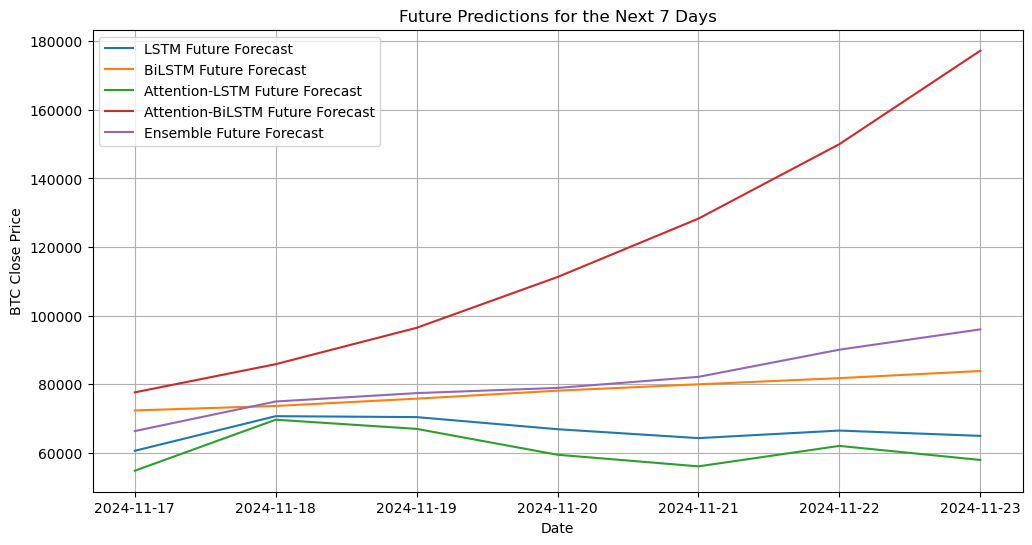

In [333]:
# Visualization
plt.figure(figsize=(12, 6))
for model_type, future_pred in future_predictions.items():
    plt.plot(future_dates, future_pred, label=f"{model_type} Future Forecast")

plt.title("Future Predictions for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("BTC Close Price")
plt.legend()
plt.grid()
plt.show()

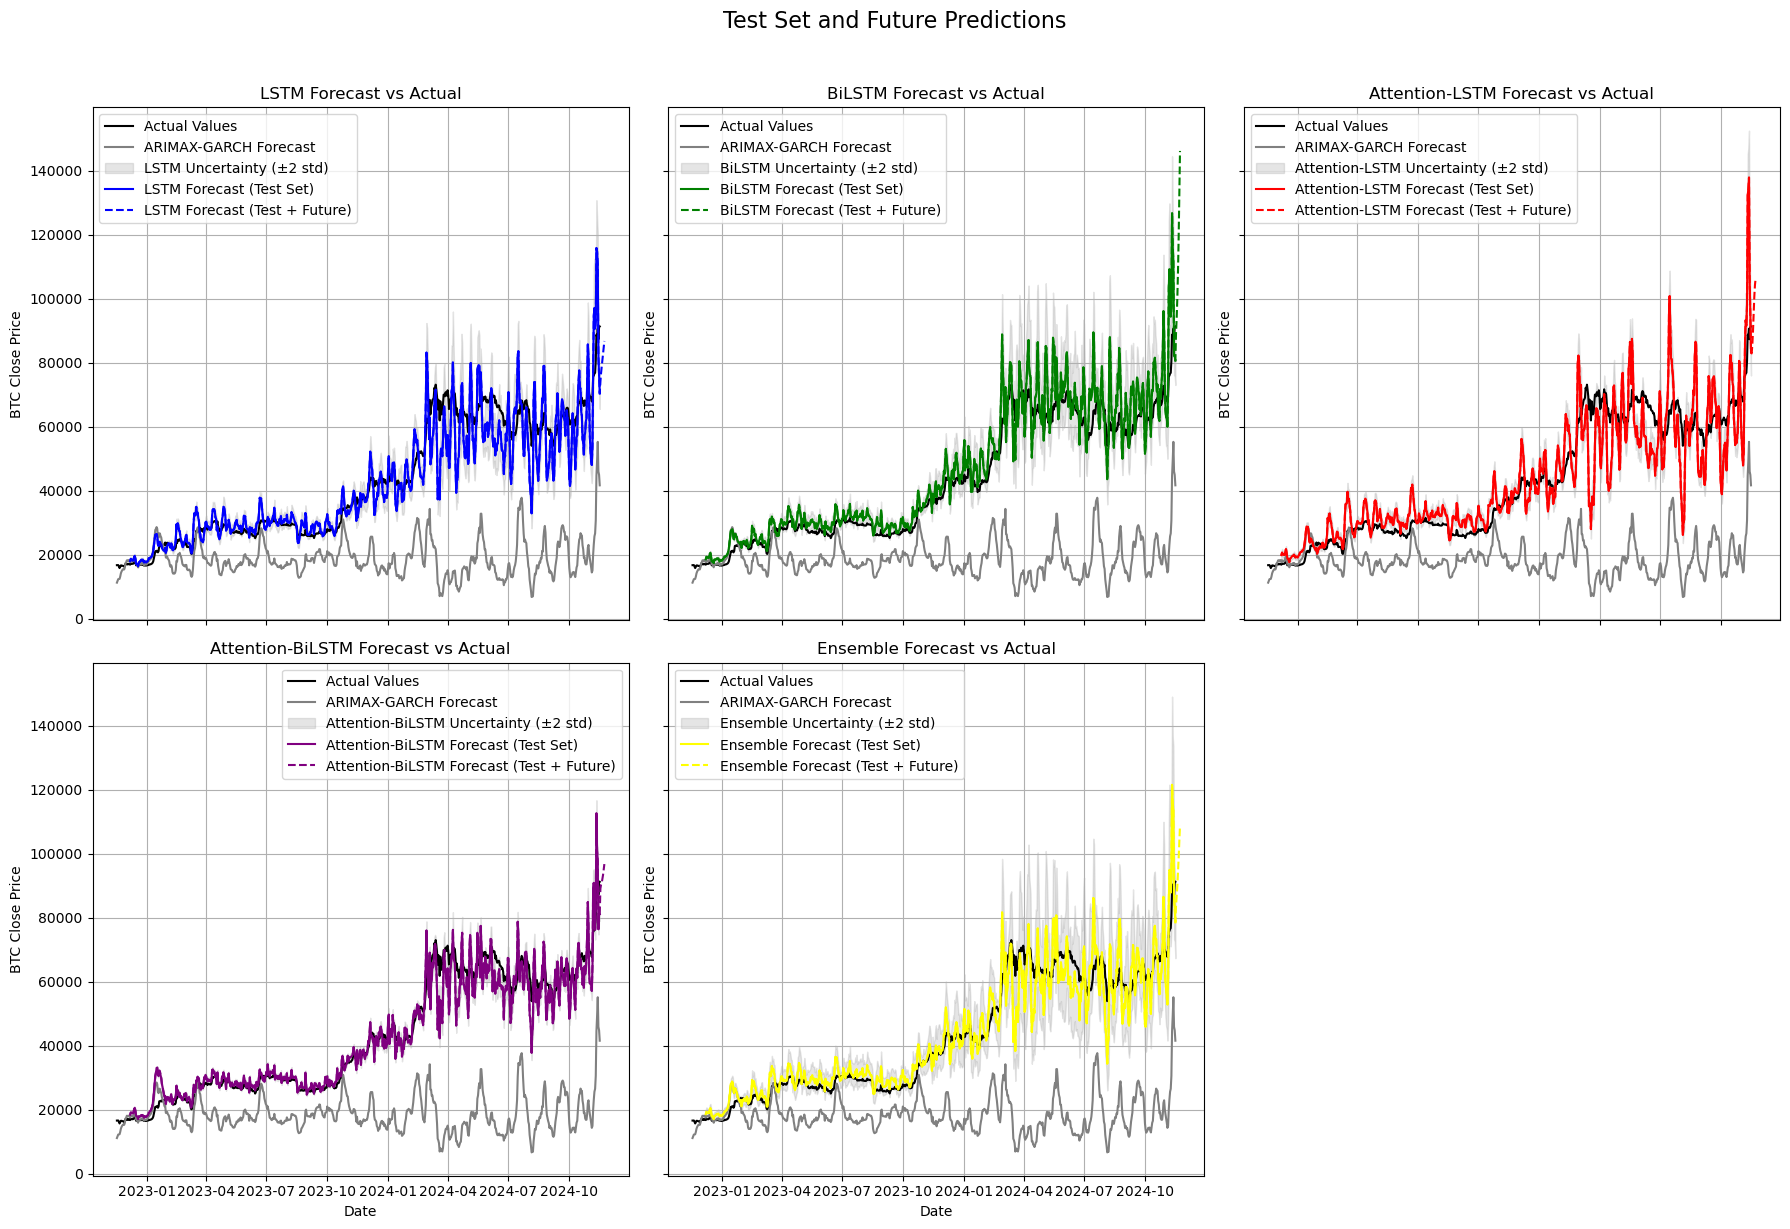

In [79]:
# Number of models (LSTM variants)
n_models = len(predictions)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define a color palette for the predictions
colors = ["blue", "green", "red", "purple", "yellow"]  # Add more colors if needed

# Add a general title for the entire plot
fig.suptitle("Test Set and Future Predictions", fontsize=16, y=1.02)

# Plot actual values and SARIMA-GARCH forecast in each subplot
for ax in axes[:n_models]:
    ax.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
    ax.plot(test_pca_df.index, test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")

# Plot each LSTM variant prediction in a separate subplot
for i, (name, pred) in enumerate(predictions.items()):
    # Reshape pred
    pred = pred.reshape(-1, 1)
    
    # Undo log transform for the combined forecast
    test_final_forecast = test_arima_garch_pred.iloc[look_back:].values.reshape(-1, 1) + pred
    lstm_pred_original = np.exp(test_final_forecast) - 1

    # Add uncertainty (if available)
    uncertainty = uncertainties.get(name)
    if uncertainty is not None:
        uncertainty = uncertainty.reshape(-1, 1)
        lower_bound = np.exp(test_final_forecast - 2 * uncertainty) - 1  # Lower bound (95% CI)
        upper_bound = np.exp(test_final_forecast + 2 * uncertainty) - 1  # Upper bound (95% CI)

        # Plot uncertainty bands for the test set
        axes[i].fill_between(
            test_pca_df.index[look_back:],
            lower_bound.flatten(),
            upper_bound.flatten(),
            color="gray",
            alpha=0.2,
            label=f"{name} Uncertainty (±2 std)"
        )

    # Plot LSTM variant predictions for the test set
    axes[i].plot(
        test_pca_df.index[look_back:],
        lstm_pred_original,
        label=f"{name} Forecast (Test Set)",
        color=colors[i]
    )

    # Combine test set and future predictions
    future_pred = future_predictions[name]  # Future predictions for the current model
    combined_dates = test_pca_df.index[look_back:].union(future_dates)  # Combine dates
    combined_predictions = np.concatenate([lstm_pred_original.flatten(), future_pred])  # Combine predictions

    # Plot combined predictions (test set + future)
    axes[i].plot(
        combined_dates,
        combined_predictions,
        label=f"{name} Forecast (Test + Future)",
        color=colors[i],
        linestyle="--"
    )

    # Set subplot title and labels
    axes[i].set_title(f"{name} Forecast vs Actual")
    axes[i].set_ylabel("BTC Close Price")
    axes[i].legend()
    axes[i].grid()

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")  # Hide unused subplots

# Set common x-label for all subplots
for ax in axes[-3:]:  # Only set x-label for the bottom row
    ax.set_xlabel("Date")

# Adjust layout for better spacing
plt.tight_layout()
# plt.savefig("../results/images/future/subplot.png")
plt.show()
plt.close()

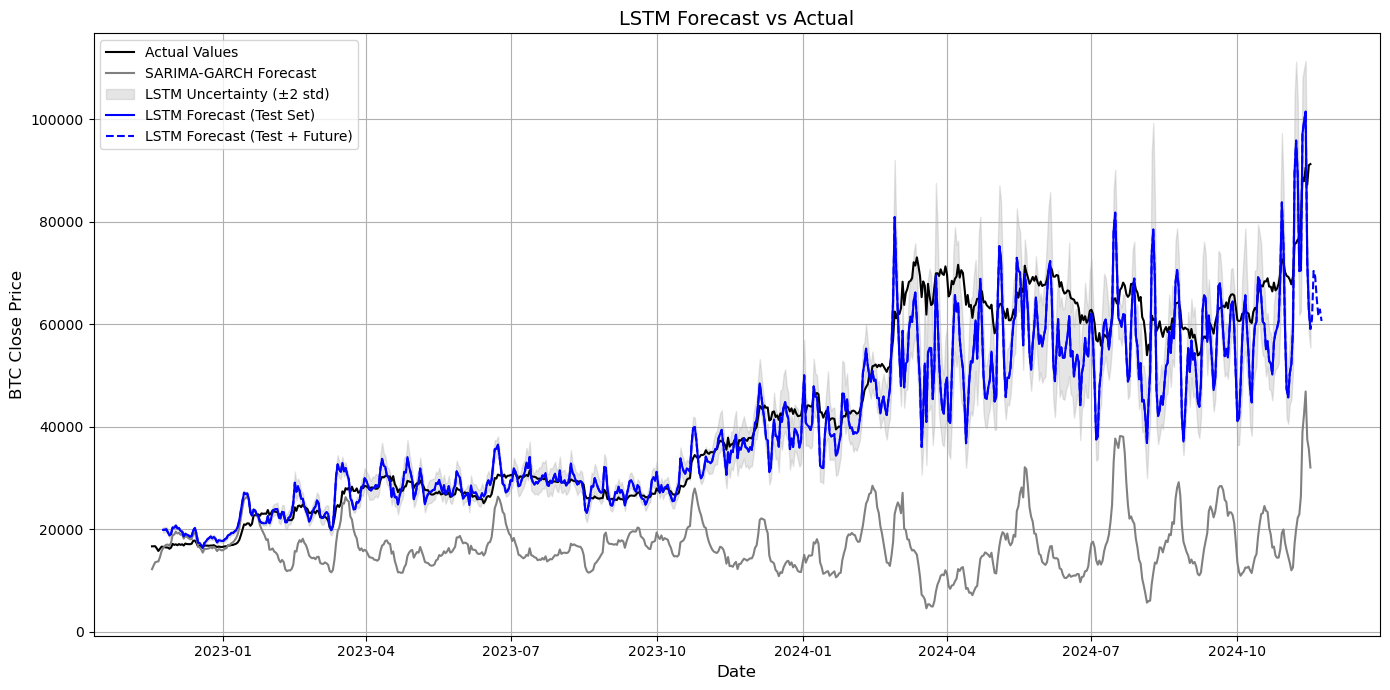

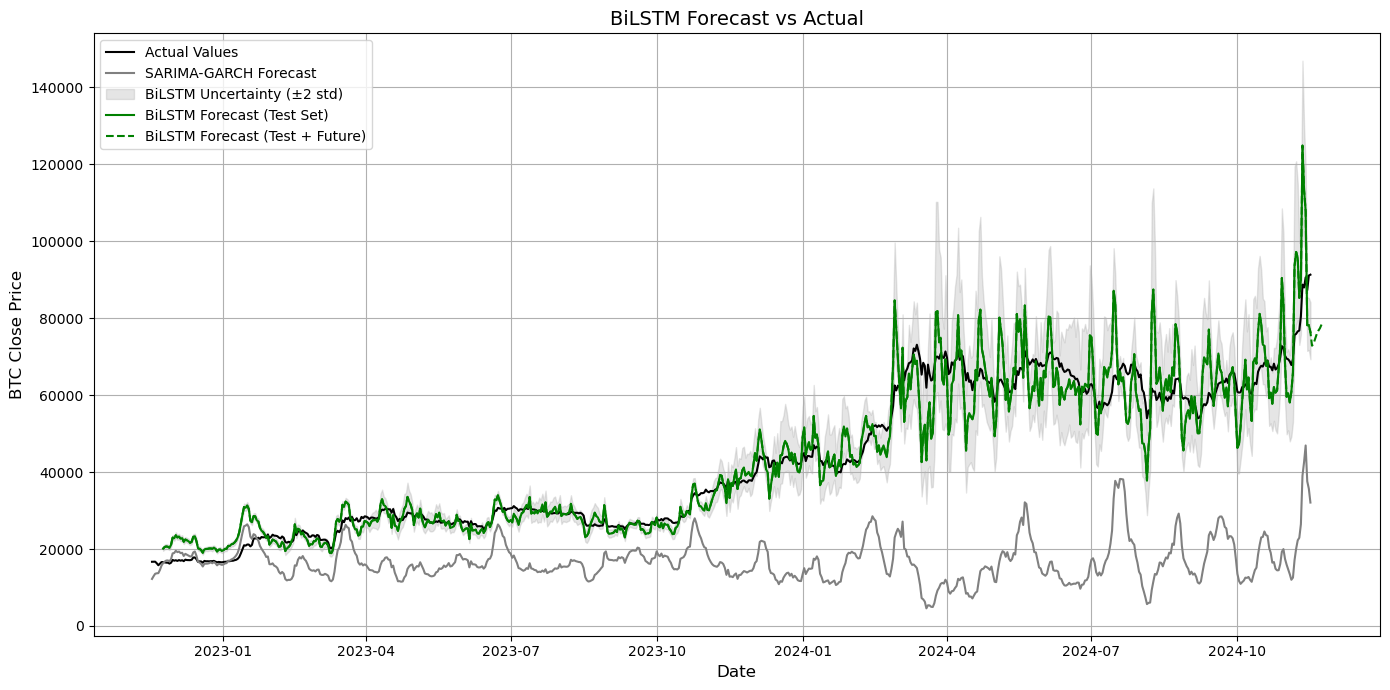

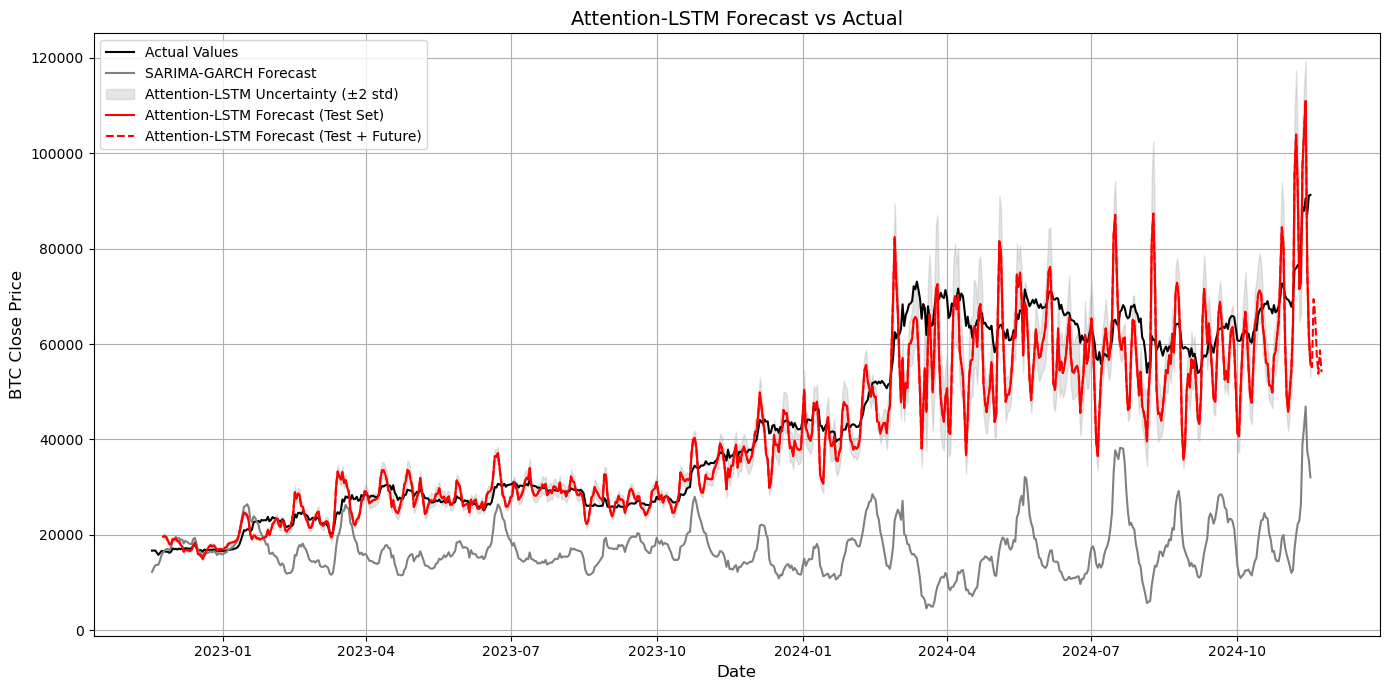

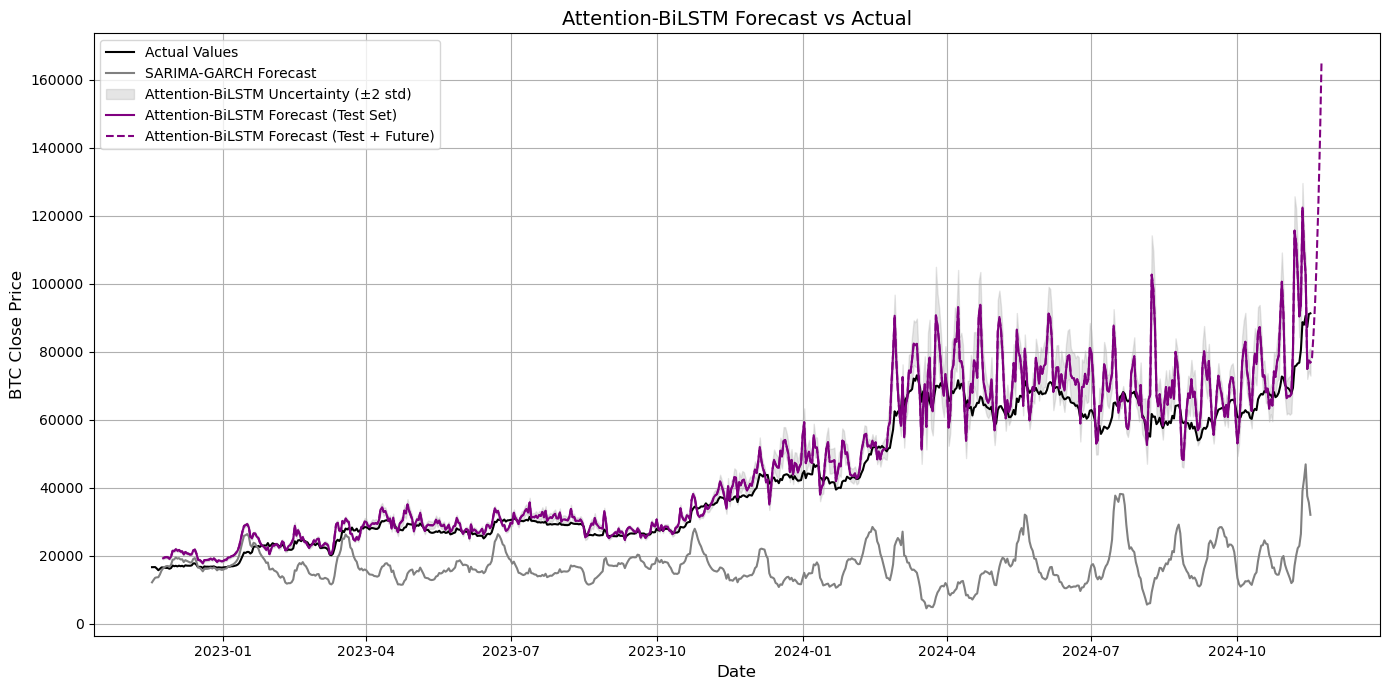

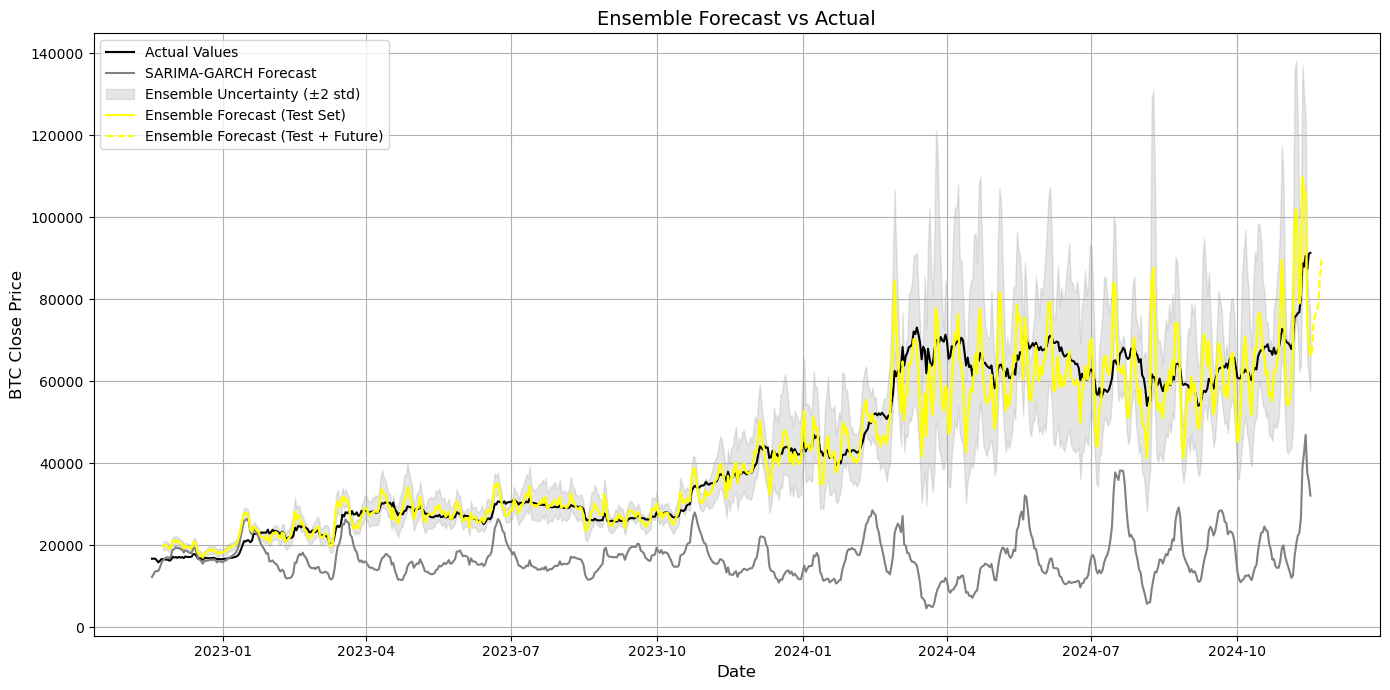

In [317]:
# Number of models (LSTM variants)
n_models = len(predictions)

# Define a color palette for the predictions
colors = ["blue", "green", "red", "purple", "yellow"]  # Add more colors if needed

# Loop through each LSTM variant and create a separate plot
for i, (name, pred) in enumerate(predictions.items()):
    # Create a new figure for each model
    fig, ax = plt.subplots(figsize=(14, 7))  # Adjust figsize for better visibility
    
    # Plot actual values and SARIMA-GARCH forecast
    ax.plot(test_pca_df.index, test_actual_values, label="Actual Values", color="black")
    ax.plot(test_pca_df.index, test_arima_garch_pred_org, label="SARIMA-GARCH Forecast", color="grey")
    
    # Reshape pred
    pred = pred.reshape(-1, 1)
    
    # Undo log transform for the combined forecast
    test_final_forecast = test_arima_garch_pred.iloc[look_back:].values.reshape(-1, 1) + pred
    lstm_pred_original = np.exp(test_final_forecast) - 1

    # Add uncertainty (if available)
    uncertainty = uncertainties.get(name)
    if uncertainty is not None:
        uncertainty = uncertainty.reshape(-1, 1)
        lower_bound = np.exp(test_final_forecast - 2 * uncertainty) - 1  # Lower bound (95% CI)
        upper_bound = np.exp(test_final_forecast + 2 * uncertainty) - 1  # Upper bound (95% CI)

        # Plot uncertainty bands for the test set
        ax.fill_between(
            test_pca_df.index[look_back:],
            lower_bound.flatten(),
            upper_bound.flatten(),
            color="gray",
            alpha=0.2,
            label=f"{name} Uncertainty (±2 std)"
        )

    # Plot LSTM variant predictions for the test set
    ax.plot(
        test_pca_df.index[look_back:],
        lstm_pred_original,
        label=f"{name} Forecast (Test Set)",
        color=colors[i]
    )

    # Combine test set and future predictions
    future_pred = future_predictions[name]  # Future predictions for the current model
    combined_dates = test_pca_df.index[look_back:].union(future_dates)  # Combine dates
    combined_predictions = np.concatenate([lstm_pred_original.flatten(), future_pred])  # Combine predictions

    # Plot combined predictions (test set + future)
    ax.plot(
        combined_dates,
        combined_predictions,
        label=f"{name} Forecast (Test + Future)",
        color=colors[i],
        linestyle="--"
    )

    # Set plot title and labels
    ax.set_title(f"{name} Forecast vs Actual", fontsize=14)
    ax.set_ylabel("BTC Close Price", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.legend()
    ax.grid()

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the figure as a separate image
    # plt.savefig(f"../results/images/future/{name}.png")
    plt.show()
    plt.close()